# Supplemental notes, getting started

We will be using the same tools that we used last week for this session.

- [pandas](pandas.pydata.org) for data handling (our dataframe library)
- [seaborn](seaborn.pydata.org) for _nice_ data visualization

We will also be using:

- [scikit-learn](scikit-learn.org) an extensive machine learning library.
- [numpy](numpy.org) - a fundamental maths library.  We won't explore it much today, but it does have some useful methods that we'll need.  It underlies all other mathematical and plotting tools that we use in Python.

We'll be using scikit-learn and it's well worth reading the documentation and high level descriptions.

A useful resource is Stack Overflow - if you have a question that sounds like 'how do I do {x}' then someone will probably have answered it on SO. Questions are also tagged by library so if you have a particular pandas question you can do something like going to https://stackoverflow.com/questions/tagged/pandas (just replace the 'pandas' in the URL with whatever library you're trying to use.

Generally answers on SO are probably a lot closer to getting you up and running than the documentation. Once you get used to the library then the documentation is generally a quicker reference. We will cover strategies for getting help in class.


## Git links

If you are just starting out using git, or are interested in learning here are some references that may be useful.

- GitKraken interface basics: https://support.gitkraken.com/start-here/interface
- Staging and committing (save current state -> local history): https://support.gitkraken.com/working-with-commits/commits
- Pushing and pulling (sync local history <-> GitHub history): https://support.gitkraken.com/working-with-repositories/pushing-and-pulling
- Forking and pull requests (request to sync your GitHub history <-> someone else's history - requires a _review_):
  - https://help.github.com/articles/about-forks/
  - https://help.github.com/articles/creating-a-pull-request-from-a-fork/

## Recap of last time

Last week we used Scikit-Learn and Seaborn to do least-squares linear regression.  This is the same kind of linear regression that you've applied countless times in Excel.  We reframed it in the context of machine learning by creating a target array with labels, a features matrix, and then we used the fit method to train the model and the predict method to try to predict labels on new observations.  

As was highlighted last week, the common linear regression approach aims to find a line that minimised the squared error between the predictions that result from that line and the observed labels in the target array.  The statistical consequences of this were discussed.  These included that the distribution of the errors that we see in our observed features is gaussian, also known as the normal distribution or the bell curve.

We ran through an example where we created perfect linear data and then added gaussian noise.  We used Seaborn to do a linear fit and show us the residuals.  In this case we saw residuals that looked scattered in a way that was consistent with gaussian error and that indicated a good fit.

When the errors are not gaussian this distorts the linear fit found, and makes it a poorer predictor than it would be in the gaussian case. Distorted linear models are a general consequence of non-gaussian errors in least squares linear regression.  The use of robust regression was also introduced as a way to lessen the impact of data outliers. 

## Import packages

In [ ]:
# Install required packages if using jupyterhub
# %pip install -r ../requirements.txt

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd

from collections import namedtuple

from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# regression_help is a python file in the same directory as this notebook
# various functions will be imported throughout the notebook so make sure this import works
from regression_help import recovery_sulphur_dataframe_with_outliers

# Exercise 1: Metal recovery vs % sulphur in feed

In this exercise, we are going to look at a typical minerals engeineering problem. The data are representative of what would be collected in laboratory batch floatation tests on samples taken from different parts of a base metal orebody.

In this exercise we're going to review the impact of outliers on linear models, and we're going to try different methods of linear regression that use other measures of line error that are less sensitive to this.

We're going to use some pre-written methods provided in the file week4_help.py, which you should find in the same directory as this notebook.  You'll need to import them.  Please review how we import methods from modules that we've written ourselves.

It's not important to understand how these methods work, just to be able to use them for the exercise.

Import metal_sulphur_recovery_with_outliers.  Then use:

```metal_sulphur_recovery_with_outliers?```

to read the docstring.

We'll use this to create Pandas dataframes with varying numbers of outliers present.

In [2]:
# from regression_help import recovery_sulphur_dataframe_with_outliers
recovery_sulphur_dataframe_with_outliers?

This should have brought up the help for the recovery_sulphur_dataframe_with_outliers method.

Let's start with no outliers. If we call this with zero as the parameter then it won't return any outliers.  Let's do that, and then plot the data.

In [3]:
recovery = recovery_sulphur_dataframe_with_outliers(0)

In [4]:
recovery.head()

,metal_recovery_percent,feed_sulphur_percent
0,46.619407,0.241570
1,68.538719,1.085903
2,64.737393,0.676091
3,68.121452,1.018158
4,69.664892,1.323587


In [5]:
sns.set(style="whitegrid")

[(0.0, 1.5),
 (0.0, 100.0),
 Text(0.5, 0, 'feed sulphur %'),
 Text(0, 0.5, 'recovery %'),
 Text(0.5, 1.0, '% metal recovery vs % sulphur in feed')]

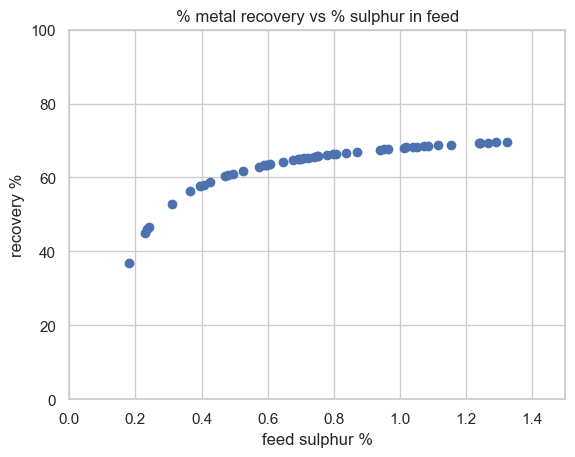

In [6]:
ax = plt.axes()
ax.plot(recovery['feed_sulphur_percent'], recovery['metal_recovery_percent'], 'o')
ax.set(xlim=(0, 1.5), ylim=(0, 100), xlabel='feed sulphur %', ylabel='recovery %',
      title='% metal recovery vs % sulphur in feed')

### Refresher from last time: Linear regression with Seaborn 
Now let's use Seaborn to try and fit a least squares linear regression to this plot.

The function we would like to try and use here is ```regplot```.

<AxesSubplot: xlabel='feed_sulphur_percent', ylabel='metal_recovery_percent'>

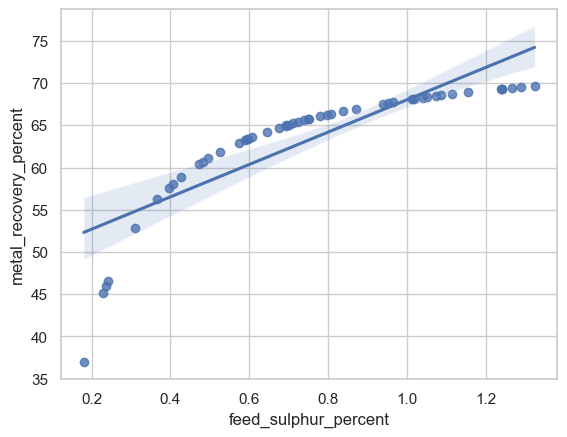

In [7]:
# Plot metal recovery against feed sulphur
sns.regplot(x='feed_sulphur_percent', y='metal_recovery_percent', data=recovery)

Note the confidence intervals in light blue that Seaborn has helpfully provided!  As you can see, confidence intervals are not very meaningful when the data doesn't conform with the assumptions of least-squares linear regression. There is a definite curve in the data and the line is unable to fit through all the points.

It is interesting that this model will predict greater than 100% recovery at feed sulphur beyond 2%, and ~40% metal recovery with no feed sulphur. Wouldn't that be nice! This may seem reasonable to a data scientist, but to a domain expert this is not possible.


Next, let's take a look at the residuals using ```residplot```.

<AxesSubplot: xlabel='feed_sulphur_percent', ylabel='metal_recovery_percent'>

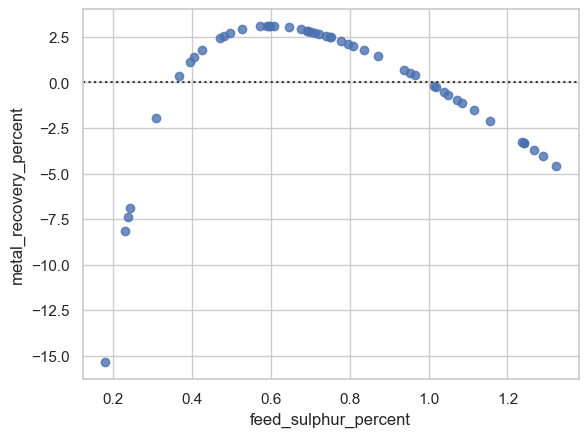

In [8]:
# Plot residuals
sns.residplot(x='feed_sulphur_percent', y='metal_recovery_percent', data=recovery)

Looking at the residuals, they are also not gaussian - they have a structure to them.  You can see that for low and high values of feed_sulphur the residuals are negative, but they go positive for middle values.  It may be helpful to review the PowerPoint presentation on linear regression from last time, which highlights this as a behaviour that indicates the underlying assumptions of least squares linear regression aren't being met.

### Transform the data

Let's transform the data to make it more linear.  We can use the transform pipeline when using scikit-learn, but it's not available when using seaborn, so we'll do it in the more basic way that we used last week - we'll simply apply the transform to the feed_sulphur_percent.

What transform would be good for this data?

Call it 'reciprocal_feed_sulphur' and store it in the ```recovery``` dataframe.

In [9]:
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']

[(0.6, 5.0),
 (0.0, 100.0),
 Text(0.5, 0, '1/feed sulphur %'),
 Text(0, 0.5, 'recovery %'),
 Text(0.5, 1.0, '% metal recovery vs % sulphur in feed')]

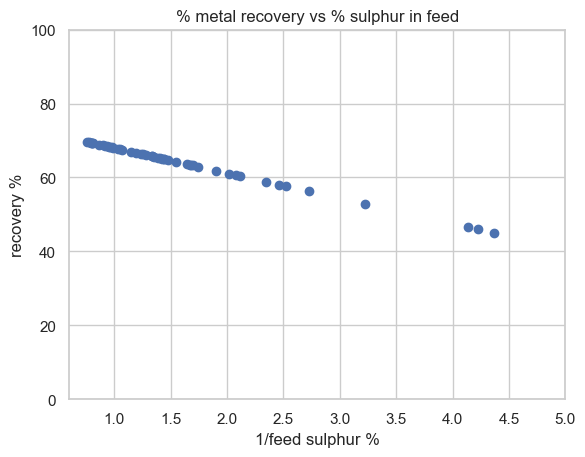

In [10]:
ax = plt.axes()
ax.plot(recovery['reciprocal_feed_sulphur'], recovery['metal_recovery_percent'], 'o')
ax.set(xlim=(0.6, 5), ylim=(0, 100), xlabel='1/feed sulphur %', ylabel='recovery %',
      title='% metal recovery vs % sulphur in feed')

That's better.  Now fitting a linear least squares line should be more sensible.  Repeat making the model using ```regplot```.

<AxesSubplot: xlabel='reciprocal_feed_sulphur', ylabel='metal_recovery_percent'>

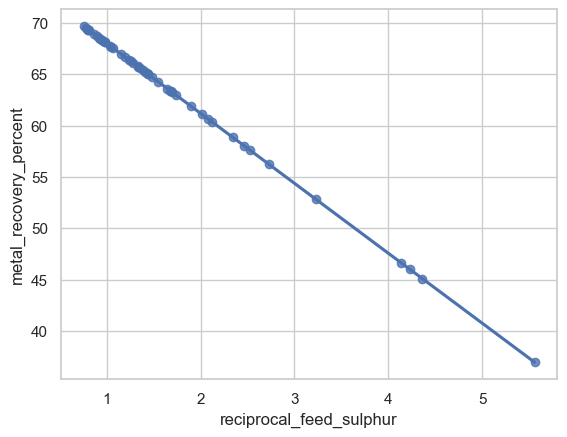

In [11]:
sns.regplot(x='reciprocal_feed_sulphur', y='metal_recovery_percent', data=recovery)

But what happens if we add outliers?  Outliers are an example of non-gaussian error and lead to poor least squares fits.  In practice, you can include them in a model if you understand the impact that they'll have on the regression, or you can take them out if why they are in the data is understood and it makes sense in the industry domain to ignore them.  But if they're being included in the model it often means that least squares will give you poor results and you should consider other line fitting methods.

Create the recovery data from with 0.2 probabability of outliers.

In [12]:
recovery = recovery_sulphur_dataframe_with_outliers(0.2)

<AxesSubplot: xlabel='reciprocal_feed_sulphur', ylabel='metal_recovery_percent'>

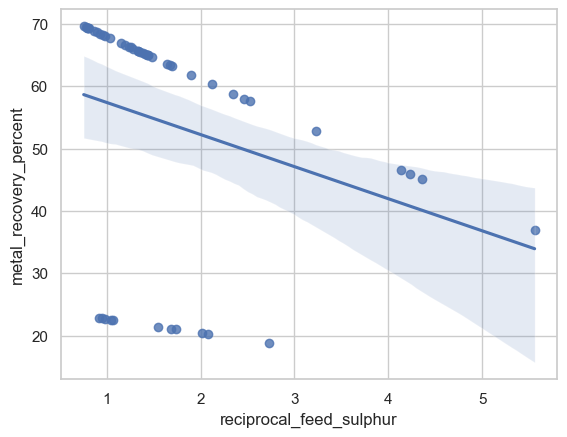

In [13]:
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']
sns.regplot(x='reciprocal_feed_sulphur', y='metal_recovery_percent', data=recovery)

Now that we've added a few outliers we see the terrible fit that only a few well placed outliers can cause.  These outliers are said to have "high leverage" because they are far away from the rest of the data, and, like having a long lever, they can move the earth (or at least your line).  Seaborn has a built in method for providing robust fitting.  Look in the help and try it out.

In [14]:
sns.regplot?

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scal

<AxesSubplot: xlabel='reciprocal_feed_sulphur', ylabel='metal_recovery_percent'>

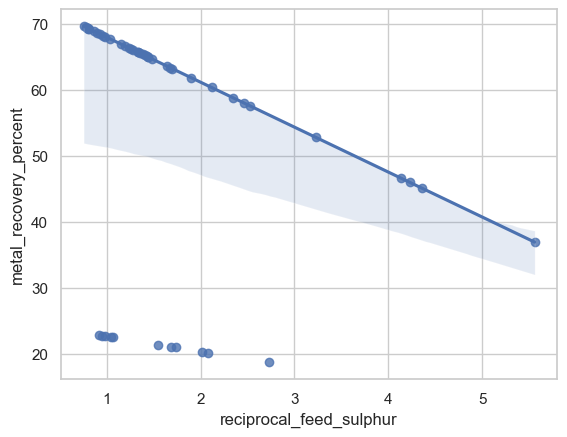

In [15]:
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']
sns.regplot(x='reciprocal_feed_sulphur', y='metal_recovery_percent', data=recovery, robust=True)

That's better.  Robust methods are based on ways of measuring central tendency other than the mean average.  Lets see what happens when I want to find an average weight and I have five people, with one being an outlier.

Weights: 72, 68, 76, 62 and 38 kilograms

If I take a mean average, it'd suggest that the average weight of peeople is about (38+62+68+72+76)/5 = 63kg.

Given the numbers that we have, this would seem a bit low.  This is analogous to how least-squares finds a mean average line through the data.

If instead we use a median average, which orders all of the numbers and picks the one in the middle (the 3rd, in a list of five numbers), then we get an average of 68kg.  This is closer to what seems intuitively correct, even with the 38kg outlier.  This is an example of how robust linear regression works, and in fact the method called Theil-Sen regression does exactly this - it finds the median line through the data.

Robust fitting methods are only resistant to outliers to a degree, and, depending on the specifics of the data and how many outliers are present, even robust methods fall over at some point.  This is often called the breakdown point of the method.  Sometimes there is underlying theory that can predict this, but often it's better to keep using exploratory visual tools to validate our models.

<AxesSubplot: xlabel='reciprocal_feed_sulphur', ylabel='metal_recovery_percent'>

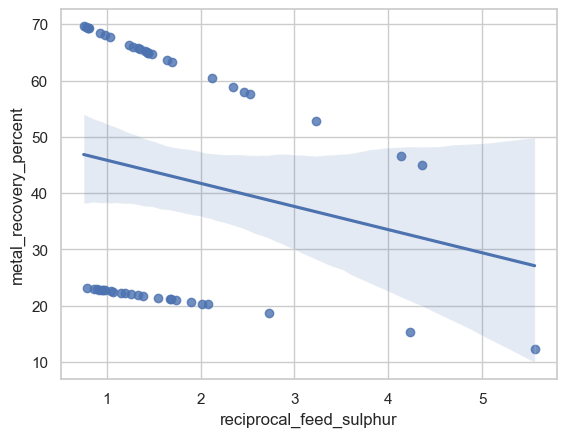

In [16]:
# Increase the outliers parameter to 0.5 and fit a robust regression, remember to apply the transform
recovery = recovery_sulphur_dataframe_with_outliers(0.5)
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']
sns.regplot(x='reciprocal_feed_sulphur', y='metal_recovery_percent', data=recovery, robust=False)

We can see that this is the breakdown point for Seaborn's robust (Theil-Sen) linear regression method. Let's try a scikit-learn robust regression.

### Refresher from last time: The Estimator API of scikit-learn

Now let's try this using scikit-learn. It has a greater range of robust methods available than Seaborn, and they are used in the same way that least squares linear regression is used.

Remember the sequence of steps for using scikit-learn for linear regression:

1. Choose a class of model by importing the appropriate estimator class.  In our case we want to import the least squares linear regression and robust regressors.  Here's how we can do it.

First import a robust regressor from scikit-learn

```from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor```

Now create an "instance" of your favorite robust regressor.  We can do it like this:

```
model = RANSACRegressor()
```

To check that this has worked look at the model object after it's created.  It should tell you about some of its settings.

```
model
```

In [17]:
# from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
model

RANSACRegressor()

2. Get the metal recovery dataframe with 20% outlier probability (0.2) and apply a reciprocal transform.  We then need to arrange a pandas dataframe into a features matrix, 'reciprocal_feed_sulphur', and a target vector, 'metal_recovery_percent'.

Remember the strange notation to get the the data into the right array shape.  Use two pairs of "[ ]" as "[[ ]]" for the features matrix.  These square brackets aren't needed in multivariate cases, they are only required for this univariate case, which is a simpler situation than scikit-learn is usually used for.

In [18]:
recovery = recovery_sulphur_dataframe_with_outliers(0.2)
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']

features_matrix = recovery[['reciprocal_feed_sulphur']]
target_array = recovery['metal_recovery_percent']

3. Split the dataset into a training and test set using ```train_test_split``` and fit the model to your data by using the fit() method of the LinearRegression object.

Look at the documentation for how to apply this.  You'll need to provide your features matrix (X) and target vector (y) as parameters to the fit method.

```
model.fit(X_train, y_train)
```

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features_matrix, target_array, test_size=0.25, random_state=100)
model.fit(x_train, y_train)

RANSACRegressor()

4. As this is a two dimensional linear model, it has two parameters: The line's intercept and slope. The convention is to add underscores to the names of the parameters it finds.

Look at the coefficients with ```model.estimator_.coef_``` (slope) and ```model.estimator_.intercept_``` (intercept).

In [20]:
model.estimator_.coef_

array([-6.81])

In [21]:
model.estimator_.intercept_

74.81

5. Take a look at the R^2 value. If more comprehensive numerical statistics are wanted then statsmodel should be used.  We used this briefly last time, and will use it again later today.

Use
```model.score```

In [22]:
model.score(x_train,y_train)

-0.15975856303128344

In [23]:
model.score(x_test,y_test)

-0.265546859169451

6. Make predictions!

But to find the smooth line that seaborn finds we need to explicitly tell scikit-learn that we want to do a prediction for all of the meal costs that we're interested in.  To generate an array of numbers to predict across, use the numpy ```linspace``` (which is short for linear spacing).

Use the ```linspace``` method in numpy like this:

```
x = np.linspace(.5, 5.5, 100)```

to create an array of 100 numbers equally spaced from .5 to 5.5.

```
This is what we need to make predictions but this collection isn't formatted correctly for scikit-learn.  To make it work with scikit-learn we next have to adjust the format with this instruction:

```
xfit = x.reshape(-1,1)
yfit = model.predict(xfit).
```

In [24]:
x = np.linspace(.5, 5.5, 100)
xfit = x.reshape(-1,1)
yfit = model.predict(xfit)

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RANSACRegressor was fitted with feature names
  warnings.warn(


Lastly, plot the data and model fit. Use matplotlib line and scatter plot.

```
plt.scatter(recovery['reciprocal_feed_sulphur'], recovery['metal_recovery_percent'],label='Data')
plt.plot(xfit, yfit,label='Model Fit')
plt.legend()
```

To set the axes labels, use ```plt.xlabel``` and ```plt.ylabel```. 

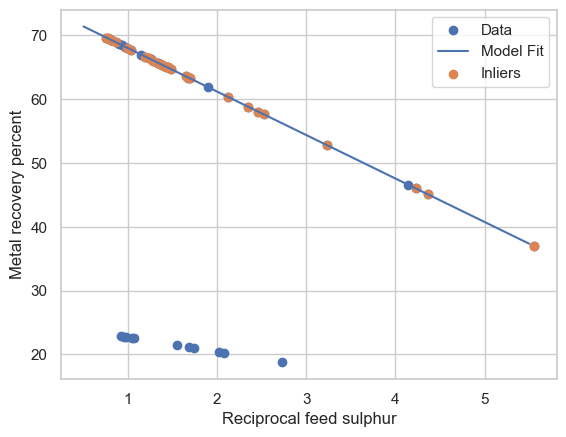

In [25]:
plt.scatter(recovery['reciprocal_feed_sulphur'], recovery['metal_recovery_percent'],label='Data')
plt.plot(xfit, yfit,label='Model Fit')
plt.xlabel('Reciprocal feed sulphur')
plt.ylabel('Metal recovery percent')
plt.scatter(x_train[model.inlier_mask_.reshape([-1,1])],y_train[model.inlier_mask_],label='Inliers')
plt.legend()

## Bonus Exercise

Consider working through these exercises in your spare time.

1. Get the metal recovery dataframe with 50% outlier probability (0.5) 
2. Re-run the regression using all the data (do not split into training and test data).
3. Plot the model fit vs actual data. 
4. Are the results repeatable? Repeat from Step 2 a couple of times to view the model fit.
5. Use the package statsmodel to do regression and output the model fit statistics (Hint: Look at `sm.OLS`)


In [48]:
# 1. Set up data with outliers
recovery = recovery_sulphur_dataframe_with_outliers(0.5)
recovery['reciprocal_feed_sulphur'] = 1/recovery['feed_sulphur_percent']

/Users/yingyap/projects/Core Skills/Oct 2022 /06-multivariate-analysis/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RANSACRegressor was fitted with feature names
  warnings.warn(


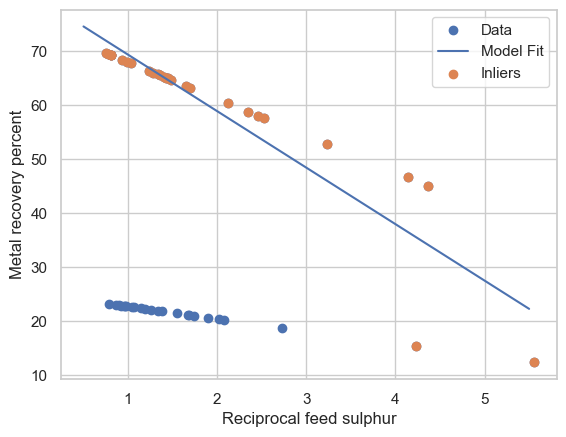

In [53]:
# 2. Run the regression using all the data with 0.5 outlier probability
ransac = RANSACRegressor()
ransac.fit(recovery[['reciprocal_feed_sulphur']], recovery['metal_recovery_percent'])


# 3. Plot model fit vs actual data 
x = np.linspace(.5, 5.5, 100)
xfit = x.reshape(-1,1)
yfit = ransac.predict(xfit)
plt.scatter(recovery['reciprocal_feed_sulphur'], recovery['metal_recovery_percent'],label='Data')
plt.plot(xfit, yfit,label='Model Fit')
plt.xlabel('Reciprocal feed sulphur')
plt.ylabel('Metal recovery percent')
inliers = ransac.inlier_mask_
plt.scatter(recovery.reciprocal_feed_sulphur[inliers],recovery.metal_recovery_percent[inliers],label='Inliers')
plt.legend()


(If you rerun the previous cell multiple times, you will find different model fits!)

In [54]:
# 5. Use the package statsmodel to do regression and output the model fit statistics
endog = recovery['reciprocal_feed_sulphur'] # Endogenous variables
exog = recovery['metal_recovery_percent'] # Exogenous variables
model = sm.OLS(endog, exog)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     reciprocal_feed_sulphur   R-squared (uncentered):                   0.513
Model:                                 OLS   Adj. R-squared (uncentered):              0.503
Method:                      Least Squares   F-statistic:                              51.55
Date:                     Wed, 09 Nov 2022   Prob (F-statistic):                    3.50e-09
Time:                             10:22:54   Log-Likelihood:                         -86.768
No. Observations:                       50   AIC:                                      175.5
Df Residuals:                           49   BIC:                                      177.4
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
metal_recovery_percent     0.0292      0.004      7.180      0.000       0.021       0.037
==============================================================================
Omnibus:                       19.931   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.274
Skew:                           1.350   Prob(JB):                     7.25e-07
Kurtosis:                       5.507   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Exercise 2:  Basis Regression using templates

#### Multichannel instruments have hundreds or thousands of channels
In multichannel instrumentation, such as XRD and spectroscopy it's common to have hundred or even thousands of spectral channels. Depending on composition of the material, the instrumentation returns different results. Often there is prior understanding so that we know how pure examples of various components would look like in the instrument. It's also the case that the behaviour of the samples and the instrument is well-approximated as a linear system.  That is, one where the whole is the sum of the known parts.  **The problem then is to find out how much of each component is present in a mixed sample.**

#### Basis regression to find out composition of material
This process is a kind of transform.  We want to transform the data from the original feature space, to a new feature space based on how much of each part is present in the observation.  To make it more concrete, if we're using a spectral instrument, which measures light intensity at every nanometre wavelength between 1000nm and 2000nm, then we have a multichannel instrument with about 1000 channels.  Basis regression says you know what each of the pure components look like to the spectrometer (i.e. a template), and you have reason to think they are additive to make a whole.  The problem then being solved is how much of each of the component parts is present in an observation.  If we have background knowledge that tells us that there could be some combination of iron, zinc, aluminium (3 pure components) in the observations, and we want to find how much of each is present, then we turn the original 1000 features into three new features. In other words, even though the spectrometer gives us hundreds and thousands of light measurements, **the critical information in the data can be reduced to a small number of features**.

#### Basis regression when you know the templates, PCA for when you don't know the templates
In this example of basis regression using templates, we know what the features look like (the templates for pure components).  PCA, which we will look at after this, doesn't make that assumption.  It can try to learn the component features from the data.  So why would you use basis regression when, superficially, it doesn't seem as clever as PCA?  Sometimes you don't have any training data for PCA, and sometimes you have prior knowledge about what you may see, and when you have this knowledge it can make sense to use it.

#### Let's do Basis regression! 

In this example we've created templates for four minerals of interest - quartz, dilithium, red kryptonite and unobtainium.  We also have drill hole data containing observations from 50 samples of these components.  Let's use template regression to estimate how much quartz, dilithium, kryptonite and unobtainium are present in each of the observations



In [74]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from regression_help import create_templates_matrix, MultichannelXAxis

In [9]:
help(MultichannelXAxis)

Help on class MultichannelXAxis in module regression_help:

class MultichannelXAxis(builtins.object)
 |  MultichannelXAxis(min_x, max_x, spacing)
 |  
 |  Set up an X axis for instrument
 |  
 |  This object is set up with three inputs, min_x is the minimum value
 |  on the axis.  In the example this is chosen to be 5.  The max_x
 |  value is the highest value on the x axis, and spacing is
 |  the x spacing between channels.  In the example these are chosen
 |  to be max_x of 90 and spacing of 0.2.  The unit is two-theta
 |  degrees, and this unit (and the axis values) come from the
 |  world of x-ray diffraction (XRD).  We're describing the x-axis
 |  of a low resolution XRD instrument.
 |  
 |  The object's as_vector method can return the x_axis as an array
 |  of numbers using numpy's linspace method.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, min_x, max_x, spacing)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  --------------------------

In [10]:
# Use MultichannelXaxis to create x_axis. 
# For the arguments, use 5 for min_x, 90 for max_x, and 0.2 for spacing
x_axis = MultichannelXAxis(5, 90, 0.2)

In [11]:
vars(x_axis)

{'_min': 5,
 '_max': 90,
 '_spacing': 0.2,
 '_channel_count': 426,
 '_label': "r'$2\theta$ (degrees)"}

Let's see what these templates for pure components look like. Here, we have 426 channels from our spectrometer. When applied to a sample of material, the instrument returns light intensity for each channel. 

In [15]:
from regression_help import create_templates_matrix
templates = create_templates_matrix()

In [16]:
# 426 channels, and 5 columns - 1 column for each pure component (quartz, dilithium, red kryptonite and unobtainium)
# and an extra column of 1's. Ignore this last column for the moment, it will come in handy later
templates.shape

(426, 5)

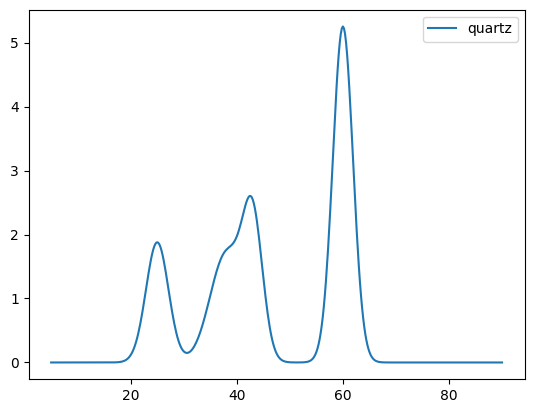

In [17]:
# Here is the quartz template. Remember that ':' means all rows, and 0 means the index 0 column.
plt.plot(x_axis.as_vector, templates[:, 0], label='quartz')
plt.legend()

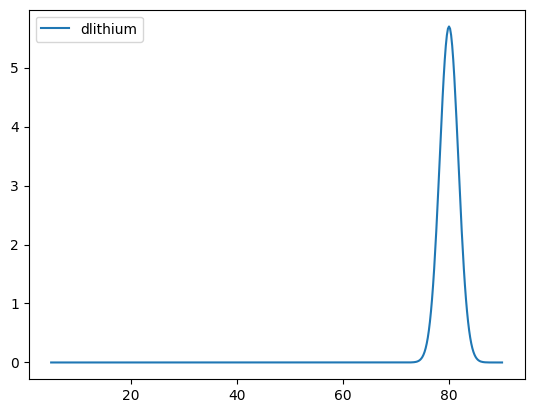

In [18]:
# Plot the Dilithium template.  
plt.plot(x_axis.as_vector, templates[:, 1],label='dlithium')
plt.legend()

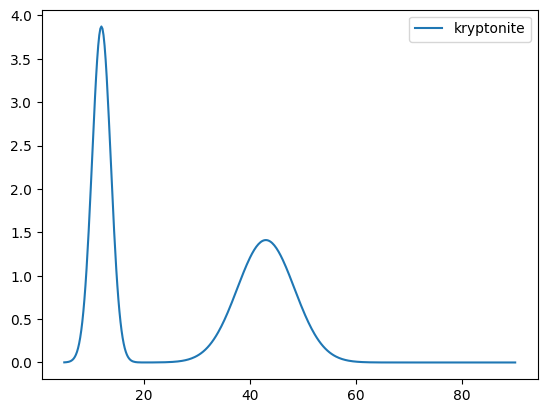

In [19]:
# Here is the kryptonite template.  
plt.plot(x_axis.as_vector, templates[:, 2],label='kryptonite')
plt.legend()

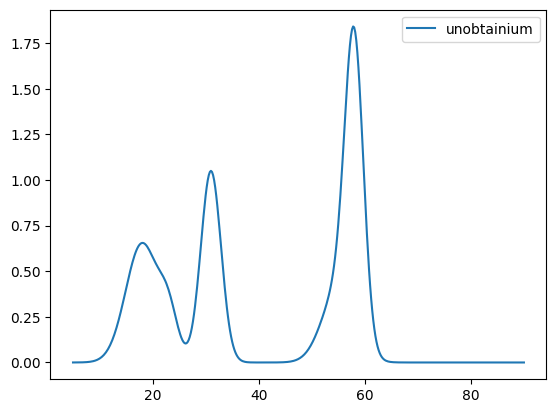

In [20]:
# Here is the unobtainium template.  
plt.plot(x_axis.as_vector, templates[:, 3],label='unobtainium')
plt.legend()

### Bonus Exercise - How are these templates created? 


Templates for our synthetic pure components can be constructed by adding gaussians together to form peaks.  While this is a synthetic example, many real-world problems are modelled as gaussians added together - this is often the case in infrared spectroscopy and also with x-ray instrumentation.  These instruments are widely used in energy and minerals.

We used a pre-defined function to help us create these templates (since they're usually known), but let's create it from scratch. 

In [23]:
# Create a matrix of zeros. We will fill in the required basis for the pure
# components later. 

# There should be one column for each of the pure components, 
# and an additional column so that a constant can be added and modelled. The number
# of rows should be the same as the number of channels in x_axis
templates_matrix = np.zeros((x_axis.channel_count, 5))

In [24]:
# We should confirm that we have 426 channels for each of the four
# templates, plus one for the constant column.
templates_matrix.shape

(426, 5)

In [25]:
# The as_vector property returns an array with all of the
# channels.  This shows that x_axis.as_vector has 426 elements.
# Each element is a measured feature for each observation.
x_axis.as_vector.shape

(426,)

In [26]:
# _apply_convolution_kernels is a bit mysteriously named, but all it does
# is it creates a gaussian peak of a specified width at particular
# positions within the template.  The details aren't too important, just
# know that we're adding together a collection of peaks to make a full
# template for our pure component.
from regression_help import _apply_convolution_kernels

In [27]:
 _apply_convolution_kernels?

In [28]:
# use _apply_convolution_kernels to create a_peak. Use the arguments, 10 for intensity, 
# 25.0 for two_theta_angle, 4 for instrument_broadening_fwhm, 3 for reflection_broadening_fwhm
a_peak = _apply_convolution_kernels(x_axis.as_vector, 10, 25, 4, 3)

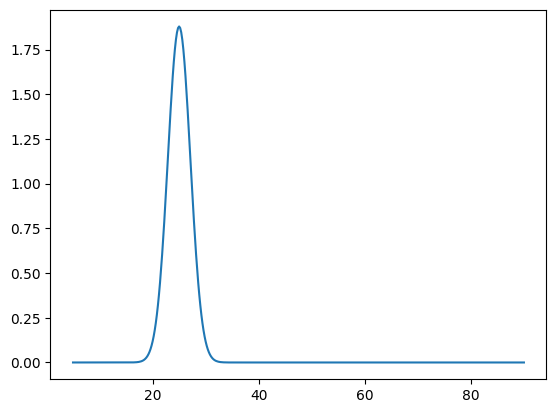

In [29]:
plt.plot(x_axis.as_vector,a_peak)

In [32]:
# Now lets create a full template for quartz.  This problem is 
# written in the language of x-ray diffraction, where peaks are
# called "reflections".  Just think of a reflection as a pointy
# area in the squiggly line.

# This makes a list of the parameters that describe each reflection.
# Then we're going to use _apply_convolution_kernels to make those
# describing parameters real as shapes.
# from collections import namedtuple
quartz_reflections = []
Reflection = namedtuple('Reflection', ('intensity', 'two_theta', 'broadening'))
first = Reflection(intensity = 10.0, two_theta = 25.0, broadening= 3.0)
quartz_reflections.append (first)
quartz_reflections.append (Reflection(13.0, 38.0, 6.0))
quartz_reflections.append (Reflection(10.0, 43.0, 2.0))
quartz_reflections.append (Reflection(25.0, 60.0, 2.0))

In [33]:
# You should have a list of 4 named tuples, each of which contains parameters
# for the 4 reflections.
quartz_reflections

[Reflection(intensity=10.0, two_theta=25.0, broadening=3.0),
 Reflection(intensity=13.0, two_theta=38.0, broadening=6.0),
 Reflection(intensity=10.0, two_theta=43.0, broadening=2.0),
 Reflection(intensity=25.0, two_theta=60.0, broadening=2.0)]

In [34]:
_apply_convolution_kernels?

In [35]:
first = quartz_reflections[0]
first_reflection_of_quartz = _apply_convolution_kernels(x_axis.as_vector, first.intensity, 
                                                        first.two_theta, 4, first.broadening)

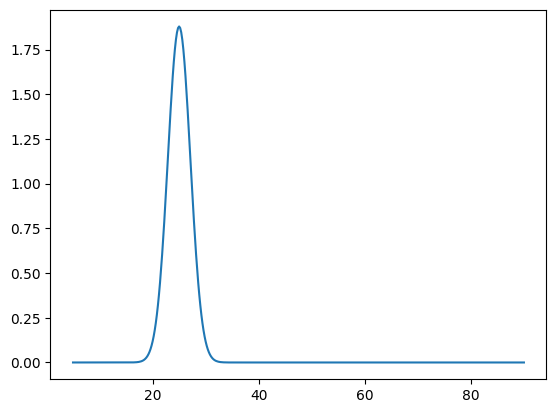

In [36]:
# Here's what the first "reflection" (or peak) looks like.
plt.plot(x_axis.as_vector, first_reflection_of_quartz)

In [37]:
# Now add it to the templates matrix.  Have you seen the += notation before?
# It means that we add the right hand side to whatever we had before
# on the left hand side and save the result back to the same place.
templates_matrix[:, 0] += first_reflection_of_quartz

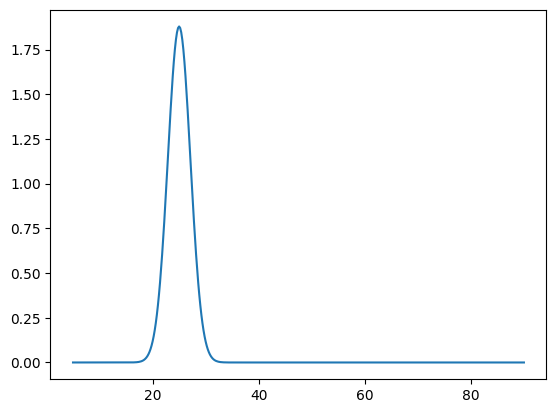

In [38]:
# Lets confirm that this worked properly by plotting the result.  It
# should look the same as first_reflection_of_quartz.
# Use plt.plot(x, y)
plt.plot(x_axis.as_vector, templates_matrix[:, 0])

In [39]:
# Lets keep going with the remaining reflections.
second = quartz_reflections[1]

In [40]:
second_reflection_of_quartz = _apply_convolution_kernels(x_axis.as_vector, second.intensity, 
                                                        second.two_theta, 4, second.broadening)

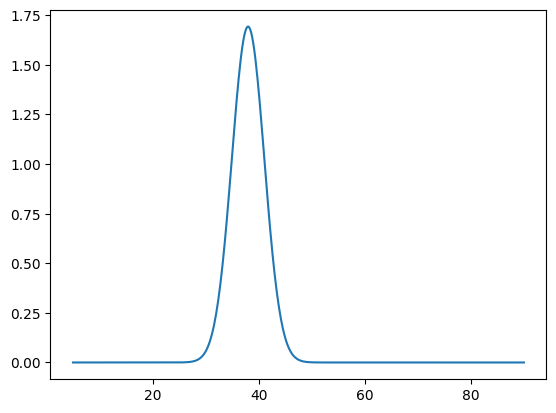

In [41]:
plt.plot(x_axis.as_vector, second_reflection_of_quartz)

In [42]:
# Notice how the += operator adds together the two peaks to make a 
# composite shape.
templates_matrix[:, 0] += second_reflection_of_quartz

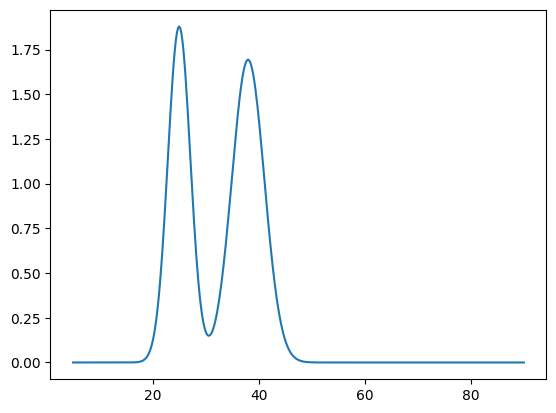

In [43]:
plt.plot(x_axis.as_vector, templates_matrix[:, 0])

In [44]:
# Keep going...
third = quartz_reflections[2]
third_reflection_of_quartz = _apply_convolution_kernels(x_axis.as_vector, third.intensity, 
                                                        third.two_theta, 4, third.broadening)
templates_matrix[:, 0] += third_reflection_of_quartz

fourth = quartz_reflections[3]
fourth_reflection_of_quartz = _apply_convolution_kernels(x_axis.as_vector, fourth.intensity, 
                                                        fourth.two_theta, 4, fourth.broadening)
templates_matrix[:, 0] += fourth_reflection_of_quartz

And now we've created the full quartz template, let's see what it looks like:

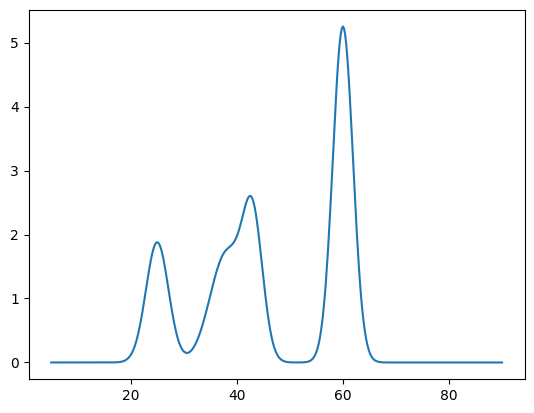

In [45]:
plt.plot(x_axis.as_vector, templates_matrix[:, 0])

## Let's continue with the basis regression

Remember that we have the templates for our 4 pure components:

In [47]:
from regression_help import create_templates_matrix
templates = create_templates_matrix()
templates

array([[1.01854097e-19, 0.00000000e+00, 1.31036862e-03, 7.95144719e-05,
        1.00000000e+00],
       [2.46246593e-19, 0.00000000e+00, 2.05535055e-03, 1.04696444e-04,
        1.00000000e+00],
       [5.90077140e-19, 0.00000000e+00, 3.18208573e-03, 1.37266699e-04,
        1.00000000e+00],
       ...,
       [9.33694070e-53, 1.68980434e-06, 6.41126849e-17, 7.41936323e-29,
        1.00000000e+00],
       [1.79869419e-53, 8.97457191e-07, 4.63834402e-17, 3.53964105e-29,
        1.00000000e+00],
       [3.42683806e-54, 4.70462071e-07, 3.35104214e-17, 1.68150948e-29,
        1.00000000e+00]])

Now we have pure components as they might be seen by our instrument.  To test our template regression method we
need to make up some compositions and some observations. In a real world problem, all you have are the templates and the observations from the instrumentation, and you will be trying to find the compositions. 

In [48]:
from regression_help import create_composition_dataframe

In [49]:
create_composition_dataframe?

In [50]:
# Make 50 compositions
compositions_dataframe = create_composition_dataframe(50)

In [51]:
compositions_dataframe.head()

,Quartz,Dilithium,Kryptonite,Unobtainium
0,5.000000,33.734294,20.051871,5.399245
1,5.000000,34.685407,22.509373,0.145264
2,5.000000,33.691945,22.478866,4.435538
3,32.249339,5.000000,20.669148,5.241627
4,29.202036,27.327283,20.710555,3.489549


The dataframe we're making can be thought of as the ground truth, or gold standard assays for each pure component. These are essentially the target values we would like to model.

Now we can use create_observations to sum the templates in proportion to how much of each pure component is present as specified in the compositions_dataframe.  This gives us our synthetic observations.

In [52]:
from regression_help import create_observations
observations_matrix = create_observations(compositions_dataframe, templates)

In [53]:
observations_matrix

array([[ 4.12407339,  4.89615121,  8.92012561, ...,  8.31921409,
         8.67937657,  7.95859829],
       [11.61786498, 10.62137555, 11.98775606, ...,  1.47318129,
         9.97766502, 10.7147534 ],
       [11.91823686, 12.74885559, 15.63982954, ..., 12.72780554,
        10.12292324, 12.57213259],
       ...,
       [ 9.15733551,  6.86790232,  8.49314456, ..., 13.43216895,
        14.22629243, 12.60674264],
       [15.37151383,  8.79898379,  7.25530006, ..., 13.86374602,
        12.58472   ,  7.48496464],
       [10.17545276,  8.35547579, 10.98810827, ..., 10.7113824 ,
        14.28944495,  4.94589364]])

In [54]:
# What do you expect the shape to be? 
observations_matrix.shape

(426, 50)

For our observations, we have 50 samples, and for each of them, our spectrometer returns a light intensity value for each channel. The spectrometer has 426 channels. 

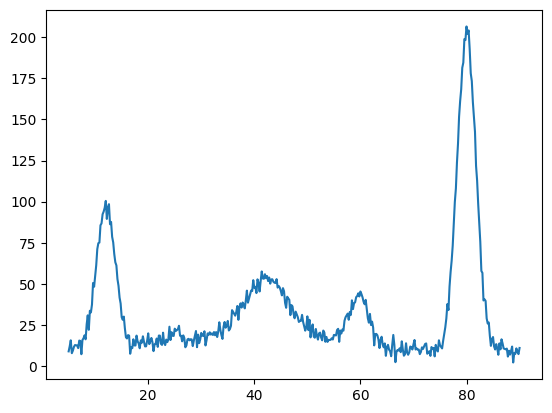

In [55]:
# Let's see the third observation (they start counting from zero). 
# The observation includes noise to resemble real data
plt.plot(x_axis.as_vector, observations_matrix[:,2])

## Bonus exercise - How are the observations created?

In real data, there is an underlying assumption is that the observations will be a "linear combination" of the parts. The observations are thus obtained by calculating linear combninations of the templates.

If we have template vectors $x_1, x_2, x_3, x_4$, then a linear combination of them is 

$$
a_1*x_1 + a_2*x_2 + a_3*x_3 + a_4*x_4
$$ 

where $a_i$ are constants, e.g. $5x_1 + 33x_2 + 20x_3 + 5x_4$  

With our `compositions_dataframe`, and the `templates`, let's make a single observation from scratch.

In [56]:
compositions_dataframe.head()

,Quartz,Dilithium,Kryptonite,Unobtainium
0,5.000000,33.734294,20.051871,5.399245
1,5.000000,34.685407,22.509373,0.145264
2,5.000000,33.691945,22.478866,4.435538
3,32.249339,5.000000,20.669148,5.241627
4,29.202036,27.327283,20.710555,3.489549


In [57]:
# Let's create an observation using the composition from the 2nd row of the compositions_dataframe
composition = compositions_dataframe.iloc[1]
composition

Quartz          5.000000
Dilithium      34.685407
Kryptonite     22.509373
Unobtainium     0.145264
Name: 1, dtype: float64

In [58]:
observation_due_to_quartz = composition['Quartz']*templates[:,0]
observation_due_to_dilithium = composition['Dilithium']*templates[:,1]
observation_due_to_kryptonite = composition['Kryptonite']*templates[:,2]
observation_due_to_unobtainium = composition['Unobtainium']*templates[:,3]

# Add them together. An observation is a linear combination of the templates.
complete_observation =  observation_due_to_quartz + observation_due_to_dilithium + \
                        observation_due_to_kryptonite + observation_due_to_unobtainium

Now to put it in a matrix, let's start by creating an empty matrix. The number of rows should be the number of channels. The number of columns should be the number of samples. 


In [59]:
# How many channels are there in template? Check templates or check x_axis.as_vector
channels_count = templates.shape[0]
channels_count

426

In [60]:
# How many observations do we have? Check compositions_dataframe.
observations_count = len(compositions_dataframe)
observations_count

50

In [61]:
# Create an empty matrix (filled with zeros) with number of channels 
# as number of rows and number of observations as number of columns
observations_matrix = np.zeros((templates.shape[0], len(compositions_dataframe)))
observations_matrix.shape

(426, 50)

Now assign that observation that we calculated

In [62]:
observations_matrix[:, 1] = complete_observation

We summed together the contribution of each phase to create an observation in a similar way to how we summed together peaks to make the pure templates. Let's have a look at some plots to make this clear  


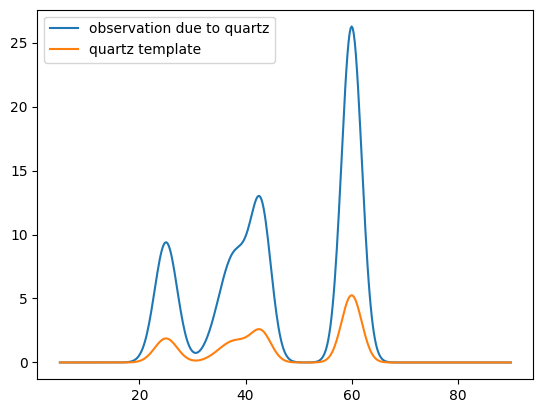

In [63]:
plt.plot(x_axis.as_vector,
         observation_due_to_quartz, label='observation due to quartz')
plt.plot(x_axis.as_vector,
         templates[:,0],  label='quartz template')
plt.legend()

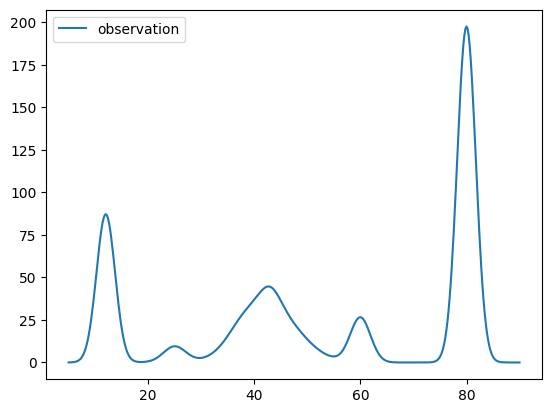

In [64]:
# Complete observation 
plt.plot(x_axis.as_vector,
         complete_observation, label='observation') 
plt.legend()

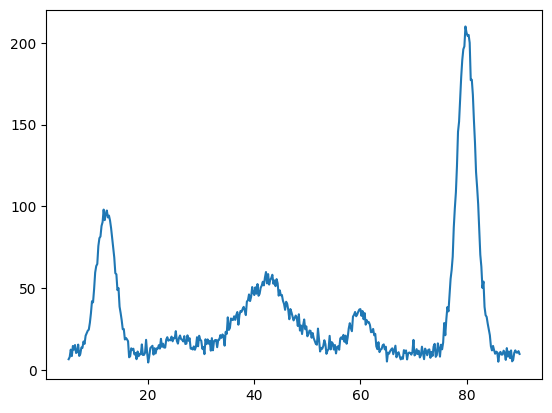

In [65]:
# Compare with our pre-defined function (which has added noise). 2nd column of observations matrix because we used the 
# 2nd row of compositions dataframe.
observations_matrix = create_observations(compositions_dataframe, templates)
plt.plot(x_axis.as_vector, observations_matrix[:,1])

Now that you have seen how an observation is created, you now understand what's in the `create_observations` function. 

## Let's recap the basis regression problem! 

We have `templates` (426 x 5 matrix) for each component (quartz, dilithium, red kryptonite and unobtainium). This is known information. We have 50 samples of material, and an `observations_matrix` (426 x 50 matrix) from our multichannel spectrometer. We would like to find out how much of each component is in each sample. 

In [66]:
from regression_help import create_templates_matrix, create_composition_dataframe, create_observations

# Templates
templates = create_templates_matrix()

# Compositions for 50 samples
compositions_dataframe = create_composition_dataframe(50)

# Create observations based on compositions and templates
observations_matrix = create_observations(compositions_dataframe, templates)

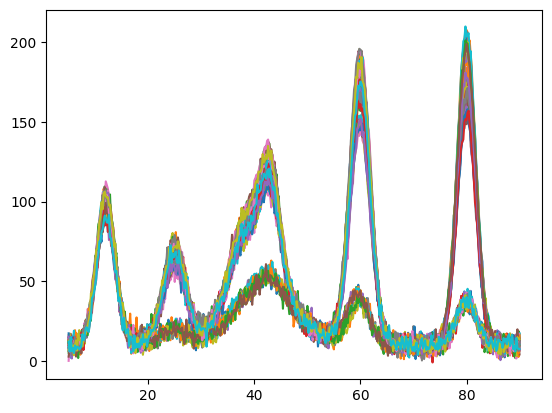

In [67]:
# Let's plot all 50 observations
observations_count = observations_matrix.shape[1]
plt.figure()
for i in np.arange(observations_count):
    plt.plot(x_axis.as_vector, observations_matrix[:,i], label = 'Observation ' + str(i))
plt.show()

Looks like there are two distinct clusters - we will save clustering for a later discussion!

## Now set up a linear regression problem to solve for the composition

Now set up a linear regression to solve for how much of each of our pure components is present in our observations.  This problem is a little bit different to our previous linear regressions in a couple of ways.

The meaning of features is more complex and maybe less intuitive than before.  This is a kind of transform, one that takes us from how much of one set of features is present (the amounts of the two-theta channels) to how much of another set of features is present (the amounts of the templates). So features have a dual meaning here.

Our instrument gives us 426 features as "two-theta" channels.  Each channel is like a single "x" number, like with feed_sulphur in the earlier example, but we have 426 of them now.  More interestingly, we want to use linear regression to express each observation in terms of how much of the template arrays are present.  There are 4 of these (plus a template of ones, that is needed for the maths book keeping to work properly).  So our features are now not a single number, but a matrix of templates.  Previously we used the [[]] notation to create a matrix out of the single x variable, but now sklearn is in its element and we can use the templates array as it is, as the feature matrix.

What the features are depends on what the question is that we're asking linear regression to solve for.  In some problems we have features, and we have the observed "amount" of each feature present.  This is what we get from our instrument, where each feature is a two-theta.  But the question we want help with is how much of our new template features are present in our observations.

The target array is also less intuitive in this case.  To re-iterate, the problem we're setting up is "How much of each feature is present in an observation?".  A feature in this case is a template.  So the target array is the instrument observations for each of the 426 channels.  The instrument observation now appears in the target array, instead of the features array, like it did with predicting metal recovery from sulphur.

Sometimes, to use machine learning to solve a problem we need to re-formulate the question in a way that makes it more tractable.  Often figuring out an appropriate set of features is a first, and sometimes difficult, step that can make a big difference to the results.

Use scikit-learn to solve this problem, and solve for the first observation.  It'll only take a few lines, once you've gone through the mental gymnastics to get to it!

The intent of manually playing with the templates and the observations was to help you build up a feel for what the data looks like that you're now trying to make a model for.

## The linear regression equation

The linear regression equation:
$$
y = a x_1 + b x_2 + c x_3 + d x_4 + Const
$$

Where we solve for coefficients $a, b, c, d$ and $Const$. 

This looks similar to the linear combination structure underlying the observations. In other words, If we can fit our observations, templates and compositions into this structure such that we solve for the compositions, then we can use linear regression. 

In [70]:
# from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
features_matrix = templates
target_array = observations_matrix[:,0]
model.fit(features_matrix, target_array)

LinearRegression()

In [71]:
# use model.coef_ to get the calculated linear regression coefficients
model.coef_

array([ 5.17536165, 33.8371072 , 20.38359103,  5.12579495,  0.        ])

How do these estimates for our phases compare with the ground truth? (Look for ground truth in ```compositions_dataframe```)

In [72]:
compositions_dataframe.head(1)

,Quartz,Dilithium,Kryptonite,Unobtainium
0,5.0,33.734294,20.051871,5.399245


Not bad!

## Optional

Use the stastmodel.api to fit a model to the first observation data frame

In [73]:
# import statsmodels.api as sm
endog = templates
exog = observations_matrix[:,0]
model = sm.OLS(exog,endog)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:39:17   Log-Likelihood:                -1094.9
No. Observations:                 426   AIC:                             2200.
Df Residuals:                     421   BIC:                             2220.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.1754      0.147     35.320      0.000       4.887       5.463
x2            33.8371      0.153    220.783      0.000      33.536      34.138
x3            20.3836      0.209     97.637      0.000      19.973      20.794
x4             5.1258      0.427     12.018      0.000       4.287       5.964
const          9.7492      0.235     41.534      0.000       9.288      10.211
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.023
Skew:                           0.017   Prob(JB):                        0.988
Kurtosis:                       3.010   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regularisation

Often your real world problem will have thousands of templates.  Linear least-squares has a habit of finding non-zero amounts of many of the templates if in a database.  This is because the least-squares criteria doesn't concern itself with how many of the templates it finds in an observation.

Why does that matter?  Often, when an instrument sees a sample, we know that the sample will only ever contain at most a dozen pure components - it may be the nature of how the small spatial volume that the sample came from, and that there are only so many pure components that are ever likely to be found in such a small space.  But noisy instrument data and operator error, together with the least-squares optimisation goal, can mean that we end up with lots of unreal false-positives for components in our observations.

In this situation we often prefer what are called regularised solvers.  A particular class of regularised solvers, called L1 regularised solvers, have a built-in preference for only seeing a small number of components.

Scikit-learn makes these as easy to do as least squares linear regression.  You should look into this if it may be relevant to your industrial problems.  An example of an L1 regularised solver is "LASSO".

#### What next?

Now that we've transformed our data according to a new, known, lower dimensional "basis", we're ready to tackle the problem of finding an underlying basis when we don't have any templates, but we do have data that we can use for training.  The most well-known and fundemental method for this is Principal Components Analysis (PCA).